<a href="https://colab.research.google.com/github/terrysu64/Machine-Learning-and-Data-Science-Projects/blob/main/abstract_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract Classifier 📝

The objective of this notebook is to constrcut an NLP model that identifies sections of medical abstracts to enable easier reading. 

Dataset source: https://arxiv.org/abs/1710.06071

In [2]:
#connect to GPU
!nvidia-smi

Thu Dec  1 03:26:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download Dataset

In [3]:
#can be downloaded from PubMed 200k RCT repository
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

#dev.txt = validation set

dev.txt  test.txt  train.txt


In [5]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [6]:
#check filenames in data directory
import os 
filenames = [f"{data_dir}/{filename}" for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### Preprocessing Data

In [7]:
#read in all lines of text file
def read_lines(file):
  """
  reads file and returns the lines of text via an array
  """

  with open(file, "r") as file: 
    return file.readlines()

In [8]:
train_lines = read_lines(f"{data_dir}/train.txt")
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

✅ **Ideal Representation**


```
for each abstract: 
[
  {
    line_number: ...,
    target: ...,
    text: ...,
    total_lines: ...,
  }
]
```

 

In [10]:
def preprocess_lines(file):
  """
  returns array of hashmaps, preprocessed in the outlined form
  """

  lines = read_lines(file)
  curr_abstract = ''; abstracts = []
  abstract_id = None

  for line in lines:
    if line.startswith('###'): abstract_id = line; curr_abstract = ''
    elif line.isspace(): 
      
      line_split = curr_abstract.splitlines()
      for i,j in enumerate(line_split):
        data={}
        target,content = j.split('\t')
        data["line_number"] = i+1
        data["target"] = target
        data["text"] = content.lower()
        data["total_lines"] = len(line_split)
        abstracts += [data]
        

    else: curr_abstract += line


  return abstracts

In [11]:
train_samples = preprocess_lines(f"{data_dir}/train.txt")
val_samples = preprocess_lines(f"{data_dir}/dev.txt")
test_samples = preprocess_lines(f"{data_dir}/test.txt")
train_samples[:15]

[{'line_number': 1,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 12},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 12},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 12},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 12},
 {'line_number': 5,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

### Further Visualizing Data

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,line_number,target,text,total_lines
0,1,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,2,METHODS,a total of @ patients with primary knee oa wer...,12
2,3,METHODS,outcome measures included pain reduction and i...,12
3,4,METHODS,pain was assessed using the visual analog pain...,12
4,5,METHODS,secondary outcome measures included the wester...,12


In [14]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [15]:
test_df.target.value_counts()

METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: target, dtype: int64

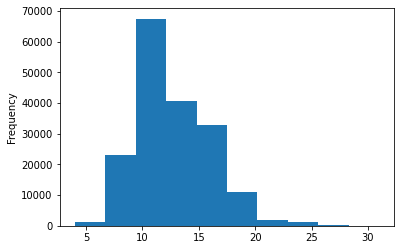

In [16]:
# sample length frequency
train_df.total_lines.plot.hist()

### Convert to Array of Sentences

In [17]:
convert = lambda sentences: sentences.tolist()
train_sentences = convert(train_df["text"])
val_sentences = convert(val_df["text"])
test_sentences = convert(test_df["text"])
train_sentences[:3]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

### Creating Numeric Lables

In [18]:
#use one-hot encoding (could use label encoding as an alternative as well)
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"] \
                                                     .to_numpy() \
                                                     .reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"] \
                                                     .to_numpy() \
                                                     .reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"] \
                                                     .to_numpy() \
                                                     .reshape(-1, 1))

tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label Encode Labels

In [19]:
#encode the target columns (labels) into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded[:5]

array([3, 2, 2, 2, 2])

In [20]:
class_names = label_encoder.classes_
num_classes = len(class_names)
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Testing Various Model

### Model 1 🤖: Baseline (TF-IDF multinomial Naive Bayes)

In [21]:
from pandas.core.reshape.merge import MultiIndex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_1 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_1.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
#evaluate baseline on validation set
model_1.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [24]:
baseline_preds = model_1.predict(val_sentences)
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing the Text for Deep Sequence Models

Text(0.5, 1.0, 'Sentence Length Distribution')

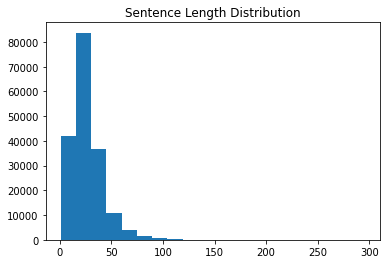

In [25]:
#prepare info for creating embedding and vectorization layers prior to building neural networks

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

lengths = [len(x.split(' ')) for x in train_sentences]
AVG_SENT_LEN = np.mean(lengths)

plt.hist(lengths, bins=20)
plt.title("Sentence Length Distribution")

In [26]:
#determine padding cutoff (enough length to fully cover 95% of sentences)

seq_len = int(np.percentile(lengths, 95))
seq_len

55

In [27]:
#vectorizer layer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000 #source: https://arxiv.org/pdf/1710.06071.pdf, table 2
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=seq_len)

#adapt to training sentences only (prevent data leakage)
text_vectorizer.adapt(train_sentences)

In [28]:
rct_20k_vocab = text_vectorizer.get_vocabulary()
print(f"Top 10 Most Common Words:\n {rct_20k_vocab[:10]}\n")
print(f"Top 10 Least Common Words:\n {rct_20k_vocab[-10:]}")

Top 10 Most Common Words:
 ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

Top 10 Least Common Words:
 ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [29]:
import random
target_sentence = random.choice(train_sentences)
print(f"Sentence:\n {target_sentence}\n")
print(f"Vectorized Sentence:\n {text_vectorizer([target_sentence])}")

Sentence:
 treatment options for wild-type braf melanoma patients remain limited .

Vectorized Sentence:
 [[  19 1855   11 3888 4550 2706   12 1656  665    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [30]:
#text embedding 
token_embed = layers.Embedding(input_dim=len(rct_20k_vocab), #the largest integer in the input should be no larger than the vocab. size
                               output_dim=128,
                               mask_zero=True, #similar to padding with 0s at the end
                               name="token_embedding")

### Creating Efficient Data Pipeline

https://www.tensorflow.org/guide/data_performance

In [31]:
#use tf.data API to turn data to tf datasets (faster via parallel loading at cost of memory)
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset= tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [32]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 2 🤖: Conv1D With Token Embedding

In [33]:
#setup model

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x) #condense output of feature vector
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [34]:
#fit model (but only look at 10% of batch / epoch)

history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 9ms/step - loss: 0.9178 - accuracy: 0.6389 - val_loss: 0.6887 - val_accuracy: 0.7367
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6644 - accuracy: 0.7542 - val_loss: 0.6367 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6250 - accuracy: 0.7729 - val_loss: 0.6011 - val_accuracy: 0.7869


In [35]:
#model evaluation

model_2.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6036 - accuracy: 0.7842


[0.6035642623901367, 0.784224808216095]

In [36]:
model_2_preds = model_2.predict(val_dataset)
conv_model_2_preds = [class_names[max([i for i in range(5)], key=lambda j:pred[j])] for pred in model_2_preds]

class_names

945/945 [==============================] - 2s 2ms/step


array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [37]:
conv_model_2_preds[:5]

['BACKGROUND', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS']

In [38]:
model_2_results = calculate_results(val_labels_encoded,
                                    tf.argmax(model_2_preds, axis=1))

model_2_results

{'accuracy': 78.42248113332451,
 'precision': 0.780719384150515,
 'recall': 0.7842248113332451,
 'f1': 0.7816178752250713}

### Model 3 🤖: Pretrained Feature Extractor (Conv1D)

*   universal sentence encoder v4



In [39]:
import tensorflow_hub as hub

extractor_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable=False,
                                 name="USE")

In [40]:
#test on arbitrary sentence
sentence = random.choice(train_sentences)
embedded_sentence = extractor_layer([sentence])
print(sentence)
print(embedded_sentence)

recently , periarticular infiltration anesthesia has become popular , but the outcome is controversial .
tf.Tensor(
[[-6.37962669e-02  3.23660634e-02  4.72505204e-02 -4.28976677e-02
  -7.31948093e-02  3.21589597e-02  5.98208494e-02 -5.17841764e-02
   7.03494325e-02  3.22678275e-02  5.72338253e-02  8.18524957e-02
   3.48311514e-02  3.68513428e-02 -3.06933839e-03 -2.27533784e-02
  -2.93385144e-03  5.30904233e-02 -6.55290857e-02 -4.74890880e-02
   2.88279867e-03  7.82839954e-02 -6.97588548e-02  3.36806662e-02
  -4.97577041e-02  4.70053703e-02 -6.15375442e-03 -5.87368980e-02
  -5.81442006e-03  4.67994213e-02  1.20961946e-02  8.69236887e-02
   2.14953404e-02 -2.84942370e-02  2.11125501e-02  6.62147906e-03
  -4.98744138e-02  3.75050306e-02  4.31618430e-02  4.77325730e-02
   4.27644886e-03 -5.74747995e-02  7.63935819e-02 -4.83939350e-02
   3.18742692e-02  1.55084701e-02  2.21939944e-02  6.62195459e-02
   1.45265637e-02  6.12410791e-02  1.04785459e-02 -7.57129490e-02
  -3.67372595e-02 -6.92690

In [41]:
inputs = layers.Input(shape=[], dtype=tf.string)
embedding = extractor_layer(inputs)
x = layers.Dense(128, activation="relu")(embedding)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="USE_feature_extractor")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [42]:
history_model_3 = model_3.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 20s 27ms/step - loss: 0.8889 - accuracy: 0.6556 - val_loss: 0.7817 - val_accuracy: 0.6981
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7388 - accuracy: 0.7117 - val_loss: 0.7165 - val_accuracy: 0.7254
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7140 - accuracy: 0.7256 - val_loss: 0.6902 - val_accuracy: 0.7314


In [43]:
model_3_preds = model_3.predict(val_dataset)
conv_model_3_preds = [class_names[max([i for i in range(5)], key=lambda j:pred[j])] for pred in model_3_preds]
model_3_results = calculate_results(val_labels_encoded,
                                    tf.argmax(model_3_preds, axis=1))

model_3_results

945/945 [==============================] - 10s 11ms/step


{'accuracy': 73.11995233681981,
 'precision': 0.7324424929095718,
 'recall': 0.731199523368198,
 'f1': 0.7307232340452684}

### Model 3 🤖: Character Embeddings (Conv1D)

*   The paper being replicated used a combination of character and token/word embeddings
*   All previously created embeddings were token embeddings





#### Preparing Necessary Layer

In [44]:
#first we need to create a character level tokenizer

split_chars = lambda text: ' '.join(list(text))
train_chars = [split_chars(x) for x in train_sentences]
val_chars = [split_chars(x) for x in val_sentences]
test_chars = [split_chars(x) for x in test_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [45]:
#average char length (to cut off sentences or pad with 0s)

char_len = [len(x) for x in train_chars]
avg_char_len = np.mean(char_len)
avg_char_len

297.7325149966674

Text(0.5, 1.0, 'Character Length Distribution')

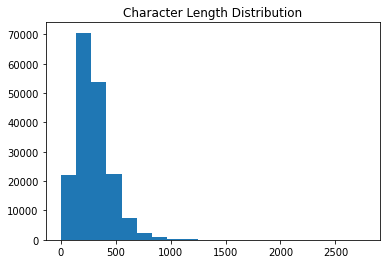

In [46]:
plt.hist(char_len, bins=20)
plt.title("Character Length Distribution")

In [47]:
char_len_95 = int(np.percentile(char_len, 95))
char_len_95

579

In [48]:
#all keyboard chars
import string
all_chars = string.ascii_lowercase + string.digits + string.punctuation + ' ' + 'U' #include space and unkown chars
all_chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ U'

In [49]:
CHAR_TOKENS_LENGTH = len(all_chars)
char_vectorizer = TextVectorization(max_tokens=CHAR_TOKENS_LENGTH,
                                    output_sequence_length=char_len_95,
                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [50]:
random_train_chars = random.choice(train_chars)
vectorized_chars = char_vectorizer([random_train_chars])
vectorized_chars

<tf.Tensor: shape=(1, 579), dtype=int64, numpy=
array([[14,  5,  3,  4,  2,  6,  3,  9,  4,  6,  3, 13,  2, 18,  8,  7,
        16, 14,  9, 13,  5, 10,  9,  4, 15,  4, 12,  5,  8,  3,  2, 11,
        13,  6,  4, 11,  5, 12,  9, 16, 11, 11,  2,  9,  9,  8,  5,  3,
         2,  9, 21,  2,  8,  9, 16,  9, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

In [51]:
#creating character level embedding
char_embed = layers.Embedding(input_dim=len(all_chars),
                              output_dim=25, #output dim in paper
                              mask_zero=True,
                              name="char_embed")

In [52]:
print(f"charified text:\n {random_train_chars}\n")
embed = char_embed(char_vectorizer([random_train_chars]))
print(f"embeded text:\n {embed}\n")
embed.shape

charified text:
 p a t i e n t s   i n   t h e   @   g r o u p s   h a d   s i m i l a r   t e c h n i c a l   s u c c e s s   r a t e s   (   @   %   v e r s u s   @   %   ,   p   =   @   )   .

embeded text:
 [[[ 0.00748057  0.04066556 -0.01824483 ...  0.03773644 -0.02183856
    0.00870638]
  [ 0.02007597  0.01555017 -0.00980158 ... -0.00179008  0.01288796
   -0.04310894]
  [-0.03107822  0.02256347  0.0491148  ...  0.03791547 -0.00873002
   -0.00033555]
  ...
  [-0.04316334 -0.01573328  0.01974216 ...  0.00490373  0.03550046
    0.01966948]
  [-0.04316334 -0.01573328  0.01974216 ...  0.00490373  0.03550046
    0.01966948]
  [-0.04316334 -0.01573328  0.01974216 ...  0.00490373  0.03550046
    0.01966948]]]



TensorShape([1, 579, 25])

#### Building the Model

In [53]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=7, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_4 = tf.keras.Model(inputs,outputs)

In [54]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [55]:
model_4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 579)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 579, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 579, 64)           11264     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 5)                 325 

In [56]:
#char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [57]:
model_4_history = model_4.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*(len(train_char_dataset))),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 7ms/step - loss: 1.2395 - accuracy: 0.5035 - val_loss: 1.0032 - val_accuracy: 0.6041
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9587 - accuracy: 0.6234 - val_loss: 0.8895 - val_accuracy: 0.6553
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.8729 - accuracy: 0.6650 - val_loss: 0.8140 - val_accuracy: 0.6971


In [58]:
model_4_pred_probs = model_4.predict(val_char_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

945/945 [==============================] - 3s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [59]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)

model_4_results

{'accuracy': 68.30729511452402,
 'precision': 0.6757289568759901,
 'recall': 0.6830729511452402,
 'f1': 0.6735523129879741}

### Model 3 🤖: Combining Pretrained Token Embeddings and Character Embeddings (hybrid embedding layer)|

In [61]:
#1. Create a token-level embedding model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = extractor_layer(token_inputs) #from model 3
token_outputs = layers.Dense(300, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

In [62]:
#2. Create a character level-model (similar to model 4 with slight modifications)
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bilstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bilstm)

In [63]:
#3. we wish to concatenate the output of both models via layers.Concatenate
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

In [70]:
#4. build a sequence of output layers
#randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [72]:
#5. construct model which takes token and character-level sequences as input and produces sequence label probabilities 
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer)

model_5.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 579)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_input[0][0]']      